In [1]:
import os,gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'
df = pd.read_csv(PATH + 'train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [3]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spectrogram_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head(5)

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [4]:
EEG_PATH = PATH + 'train_eegs/'

row = train.iloc[1]
eeg_id = row['eeg_id']

eeg_file_path = os.path.join(EEG_PATH, f'{eeg_id}.parquet')
sample_eeg_data = pd.read_parquet(eeg_file_path)
sample_eeg_data = sample_eeg_data.iloc[:, :-1]
sample_eeg_data = sample_eeg_data.iloc[:, [col for col in range(sample_eeg_data.shape[1]) if col not in [8, 9, 10]]]

start_time_point = int((sample_eeg_data.shape[0] - 10_000) // 2)

eeg_slice = sample_eeg_data.iloc[start_time_point : start_time_point + 10_000, :]

eeg_slice

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fp2,F4,C4,P4,F8,T4,T6,O2
3800,14.36,25.790001,34.560001,58.750000,8.51,0.00,-8.51,0.27,-42.799999,-4.250000,28.440001,11.96,-47.320000,0.00,-15.680000,-1.86
3801,13.56,25.520000,35.090000,61.139999,7.18,0.00,-6.11,3.72,-40.939999,-2.920000,30.040001,15.15,-43.860001,1.60,-11.170000,3.72
3802,12.23,23.389999,34.560001,60.349998,6.11,-0.80,-7.44,4.25,-39.340000,-4.250000,28.440001,14.09,-44.130001,3.46,-11.170000,4.25
3803,10.90,22.330000,31.100000,55.290001,5.85,-1.86,-8.51,2.66,-38.279999,-6.650000,25.790001,11.70,-44.660000,1.33,-13.290000,1.60
3804,8.51,19.670000,27.910000,52.369999,2.66,-2.66,-6.65,1.60,-39.610001,-8.510000,24.459999,9.84,-47.049999,1.33,-14.090000,-1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13795,8.24,15.150000,4.790000,34.029999,-8.51,-11.70,-9.57,-10.10,23.389999,-28.709999,7.440000,-7.71,-23.660000,0.00,-22.860001,-11.17
13796,8.77,16.219999,7.440000,38.810001,-8.24,-11.17,-7.98,-5.32,25.520000,-24.990000,9.840000,-2.92,-21.530001,3.99,-17.809999,-6.65
13797,8.24,17.549999,9.840000,42.270000,-9.84,-11.96,-3.46,-1.06,27.650000,-23.129999,11.960000,1.60,-21.270000,5.05,-14.090000,-3.19
13798,10.10,18.610001,11.960000,45.459999,-7.18,-9.84,-3.19,0.80,28.180000,-22.059999,14.090000,2.39,-19.139999,7.44,-10.900000,-1.60


In [5]:
FLAG = True

In [6]:
if FLAG:
    fs = 200
    EEG_PATH = PATH + 'train_eegs/'
    all_eeg_data = np.zeros((len(train), 10000, 19))

    for row_idx in range(len(train)):
        print(row_idx, end = ", ")
        row = train.iloc[row_idx]
        eeg_id = row['eeg_id']

        eeg_file_path = os.path.join(EEG_PATH, f'{eeg_id}.parquet')
        eeg_data = pd.read_parquet(eeg_file_path)
        eeg_data = eeg_data.iloc[:, :-1]
        #eeg_data = eeg_data.iloc[:, [col for col in range(eeg_data.shape[1]) if col not in [8, 9, 10]]]
        start_time_point = int((eeg_data.shape[0] - 10_000) // 2)

        eeg_slice = eeg_data.iloc[start_time_point : start_time_point + 10_000, :]

        all_eeg_data[row_idx, :, :] = eeg_slice

    print("Shape of all_eeg_data:", all_eeg_data.shape)
else:
    print("FLAG is set to False. The code below is not executed.")

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

# Feature Extraction

In [7]:
import scipy.stats

def extract_eeg_features(eeg_data):
    """
    Extract features from EEG data, including LL Spec, LP Spec, RP Spec, RL Spec
    
    Parameters:
    - eeg_data: EEG data with shape (number of samples, time points, number of electrodes)
    
    Returns:
    - Feature matrix with shape (number of samples, number of features)
    """
    # Initialize the feature matrix
    num_samples, num_time_points, num_electrodes = eeg_data.shape
    num_features = 8 * num_electrodes  # Mean, standard deviation, minimum, maximum, skewness, kurtosis, energy, entropy for each electrode + 4 global features
    features = np.zeros((num_samples, num_features))

    # Extract features
    for sample_idx in range(num_samples):
        for electrode_idx in range(num_electrodes):
            electrode_data = eeg_data[sample_idx, :, electrode_idx]
            feature_idx = electrode_idx * 8

            # Mean
            features[sample_idx, feature_idx] = np.mean(electrode_data)
            # Standard deviation
            features[sample_idx, feature_idx + 1] = np.std(electrode_data)
            # Minimum
            features[sample_idx, feature_idx + 2] = np.min(electrode_data)
            # Maximum
            features[sample_idx, feature_idx + 3] = np.max(electrode_data)
            # Skewness
            features[sample_idx, feature_idx + 4] = scipy.stats.skew(electrode_data)
            # Kurtosis
            features[sample_idx, feature_idx + 5] = scipy.stats.kurtosis(electrode_data)
            # Energy
            features[sample_idx, feature_idx + 6] = np.sum(electrode_data**2) / len(electrode_data)
            # Entropy
            features[sample_idx, feature_idx + 7] = scipy.stats.entropy(np.abs(electrode_data))
        # Additional features: LL Spec, LP Spec, RP Spec, RL Spec
        ll_spec = (np.abs(np.fft.fft(eeg_data[sample_idx, :, 0] - eeg_data[sample_idx, :, 4]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 4] - eeg_data[sample_idx, :, 5]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 5] - eeg_data[sample_idx, :, 6]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 6] - eeg_data[sample_idx, :, 7]))**2) / 4
        features[sample_idx, -4] = np.mean(ll_spec)

        lp_spec = (np.abs(np.fft.fft(eeg_data[sample_idx, :, 0] - eeg_data[sample_idx, :, 1]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 1] - eeg_data[sample_idx, :, 2]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 2] - eeg_data[sample_idx, :, 3]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 3] - eeg_data[sample_idx, :, 7]))**2) / 4
        features[sample_idx, -3] = np.mean(lp_spec)

        rp_spec = (np.abs(np.fft.fft(eeg_data[sample_idx, :, 8] - eeg_data[sample_idx, :, 9]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 9] - eeg_data[sample_idx, :, 10]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 10] - eeg_data[sample_idx, :, 11]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 11] - eeg_data[sample_idx, :, 15]))**2) / 4
        features[sample_idx, -2] = np.mean(rp_spec)

        rl_spec = (np.abs(np.fft.fft(eeg_data[sample_idx, :, 8] - eeg_data[sample_idx, :, 12]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 12] - eeg_data[sample_idx, :, 13]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 13] - eeg_data[sample_idx, :, 14]))**2 +
                   np.abs(np.fft.fft(eeg_data[sample_idx, :, 14] - eeg_data[sample_idx, :, 15]))**2) / 4
        features[sample_idx, -1] = np.mean(rl_spec)
    return features

In [8]:
import numpy as np
import scipy

from scipy.stats import skew, kurtosis
from scipy.stats.mstats import moment
from sklearn.preprocessing import StandardScaler

if FLAG:
    extracted_features = extract_eeg_features(all_eeg_data)
    print("Shape of extracted features:", extracted_features.shape)
else:
    print("FLAG is set to False. The code below is not executed.")

Shape of extracted features: (17089, 152)


In [9]:
if FLAG:
    mean_values = np.nanmean(extracted_features, axis=0)
    nan_indices = np.isnan(extracted_features)
    extracted_features[nan_indices] = np.take(mean_values, nan_indices.nonzero()[1])
    print("Shape of eeg_features after replacing NaN values:", extracted_features.shape)
    save_path = '/kaggle/working/extracted_eeg_features.npy'
    np.save(save_path, extracted_features)
    print(f"Extracted EEG features saved at: {save_path}")
else:
    extracted_features = np.load('/kaggle/input/8-basic-feaatures-with-eeg/extracted_eeg_features (1).npy')
    print("Shape of extracted features:", extracted_features.shape)

Shape of eeg_features after replacing NaN values: (17089, 152)
Extracted EEG features saved at: /kaggle/working/extracted_eeg_features.npy


In [10]:
ef = pd.DataFrame(extracted_features)
ef

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
0,-79.529651,83.460272,-517.090027,404.309998,-0.027734,2.005202,1.329058e+04,8.961696,-64.849500,75.725399,...,1.216500e+04,8.913791,-11.787523,120.779476,-452.679993,432.390015,6.289477e+07,7.429826e+07,7.093432e+07,1.461899e+08
1,-20.181530,94.790541,-298.269989,156.580002,-0.960788,0.639752,9.392541e+03,8.746809,-7.831750,28.856480,...,1.124051e+03,9.005185,-16.719044,17.138080,-71.239998,44.930000,1.215599e+07,2.479119e+07,1.617726e+07,1.382376e+07
2,-10.763163,22.371266,-76.570000,70.870003,0.162133,0.138468,6.163192e+02,8.943916,15.424412,15.102230,...,5.675354e+02,9.002714,24.210858,16.624828,-49.139999,80.480003,4.034639e+06,7.627561e+06,4.916761e+06,1.321245e+08
3,-35.750603,403.298000,-750.909973,714.359985,-0.000355,-1.459129,1.639274e+05,9.059944,-16.929795,385.719363,...,1.526239e+05,9.063005,-6.154692,387.257859,-638.219971,733.250000,1.032993e+07,1.069647e+07,2.529107e+07,1.857067e+07
4,20.348469,57.884569,-201.000000,278.970001,1.034270,0.818301,3.764683e+03,8.773467,-9.144577,13.398387,...,6.534547e+02,8.899197,-32.158577,29.049761,-132.380005,70.300003,1.141357e+07,1.512071e+07,1.184358e+08,5.215627e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,-29.315232,37.759552,-141.160004,103.410004,0.005224,-0.006260,2.285167e+03,8.945325,-20.578145,33.575589,...,3.174981e+02,8.947985,-14.392259,15.308998,-62.470001,23.660000,4.712752e+06,4.029522e+06,1.587773e+07,1.020242e+07
17085,-9.084382,63.436963,-147.809998,452.459991,3.075695,15.201727,4.106774e+03,8.780077,-30.259552,32.122936,...,4.920610e+02,8.917529,11.003384,18.024999,-61.939999,74.970001,2.708084e+07,8.272742e+06,2.298465e+07,1.599514e+07
17086,7449.374302,4338.892099,-1056.729980,27589.179688,-1.099522,-0.721300,7.431916e+07,8.938394,7463.468708,4310.732773,...,7.562658e+07,9.006915,7530.877156,4212.189109,-2798.570068,12574.690430,4.967833e+08,5.270001e+08,4.124236e+10,2.973337e+10
17087,-491.459309,316.657879,-2188.120117,-234.139999,-2.835735,8.590838,3.418045e+05,9.060994,-444.871774,226.061686,...,2.571563e+05,9.079527,-40.548878,35.950703,-185.529999,37.720001,1.307254e+08,4.059498e+07,7.466074e+08,1.203464e+10


# Label

In [11]:
train_copy = train.copy()
ycol = [c for c in train_copy.columns if c in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
cd = {'Seizure':'seizure_vote', 'GPD':'gpd_vote', 'LRDA':'lrda_vote', 'Other':'other_vote', 'GRDA':'grda_vote', 'LPD':'lpd_vote'}
train_copy['target'] = train_copy['target'].map(cd)
for i in range(len(train_copy)):
    c = train_copy['target'][i]
    train_copy[c][i] = train_copy[c][i]+10 #adding weight to expert consensus

ysum = train_copy[ycol].sum(axis=1) 
for c in ycol:
    train_copy[c] = (train_copy[c] / ysum).astype(np.float64)

In [12]:
label = train_copy[ycol]
label.shape

(17089, 6)

# Model

In [13]:
ef

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
0,-79.529651,83.460272,-517.090027,404.309998,-0.027734,2.005202,1.329058e+04,8.961696,-64.849500,75.725399,...,1.216500e+04,8.913791,-11.787523,120.779476,-452.679993,432.390015,6.289477e+07,7.429826e+07,7.093432e+07,1.461899e+08
1,-20.181530,94.790541,-298.269989,156.580002,-0.960788,0.639752,9.392541e+03,8.746809,-7.831750,28.856480,...,1.124051e+03,9.005185,-16.719044,17.138080,-71.239998,44.930000,1.215599e+07,2.479119e+07,1.617726e+07,1.382376e+07
2,-10.763163,22.371266,-76.570000,70.870003,0.162133,0.138468,6.163192e+02,8.943916,15.424412,15.102230,...,5.675354e+02,9.002714,24.210858,16.624828,-49.139999,80.480003,4.034639e+06,7.627561e+06,4.916761e+06,1.321245e+08
3,-35.750603,403.298000,-750.909973,714.359985,-0.000355,-1.459129,1.639274e+05,9.059944,-16.929795,385.719363,...,1.526239e+05,9.063005,-6.154692,387.257859,-638.219971,733.250000,1.032993e+07,1.069647e+07,2.529107e+07,1.857067e+07
4,20.348469,57.884569,-201.000000,278.970001,1.034270,0.818301,3.764683e+03,8.773467,-9.144577,13.398387,...,6.534547e+02,8.899197,-32.158577,29.049761,-132.380005,70.300003,1.141357e+07,1.512071e+07,1.184358e+08,5.215627e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,-29.315232,37.759552,-141.160004,103.410004,0.005224,-0.006260,2.285167e+03,8.945325,-20.578145,33.575589,...,3.174981e+02,8.947985,-14.392259,15.308998,-62.470001,23.660000,4.712752e+06,4.029522e+06,1.587773e+07,1.020242e+07
17085,-9.084382,63.436963,-147.809998,452.459991,3.075695,15.201727,4.106774e+03,8.780077,-30.259552,32.122936,...,4.920610e+02,8.917529,11.003384,18.024999,-61.939999,74.970001,2.708084e+07,8.272742e+06,2.298465e+07,1.599514e+07
17086,7449.374302,4338.892099,-1056.729980,27589.179688,-1.099522,-0.721300,7.431916e+07,8.938394,7463.468708,4310.732773,...,7.562658e+07,9.006915,7530.877156,4212.189109,-2798.570068,12574.690430,4.967833e+08,5.270001e+08,4.124236e+10,2.973337e+10
17087,-491.459309,316.657879,-2188.120117,-234.139999,-2.835735,8.590838,3.418045e+05,9.060994,-444.871774,226.061686,...,2.571563e+05,9.079527,-40.548878,35.950703,-185.529999,37.720001,1.307254e+08,4.059498e+07,7.466074e+08,1.203464e+10


In [14]:
# Standardize the extracted features
scaler = StandardScaler()
standardized_features = scaler.fit_transform(extracted_features)

# Convert the standardized features back to a DataFrame if needed
standardized_ef = pd.DataFrame(standardized_features)

# Display the shape of standardized features
print("Shape of standardized features:", standardized_ef.shape)

Shape of standardized features: (17089, 152)


In [15]:
standardized_ef

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
0,-0.169391,-0.201291,0.132038,-0.177797,-0.024797,-0.066765,-0.114863,0.439596,-0.171679,-0.204048,...,-0.105263,0.100374,-0.085086,-0.164425,0.143081,-0.161782,-0.104386,-0.111788,-0.102441,-0.097755
1,-0.109331,-0.192467,0.223045,-0.219131,-0.620400,-0.106629,-0.115021,-0.469352,-0.081826,-0.244861,...,-0.105855,0.501448,-0.091888,-0.246251,0.301250,-0.232319,-0.104903,-0.112358,-0.103025,-0.099240
2,-0.099800,-0.248872,0.315251,-0.233431,0.096402,-0.121264,-0.115378,0.364389,-0.045177,-0.256838,...,-0.105884,0.490606,-0.035439,-0.246656,0.310414,-0.225848,-0.104986,-0.112556,-0.103145,-0.097913
3,-0.125087,0.047821,0.034792,-0.126064,-0.007320,-0.167906,-0.108738,0.855171,-0.096163,0.065895,...,-0.097733,0.755192,-0.077318,0.045961,0.066144,-0.107011,-0.104922,-0.112521,-0.102928,-0.099187
4,-0.068316,-0.221212,0.263500,-0.198710,0.653120,-0.101417,-0.115250,-0.356590,-0.083895,-0.258322,...,-0.105880,0.036326,-0.113181,-0.236846,0.275897,-0.227701,-0.104911,-0.112470,-0.101934,-0.093543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,-0.118575,-0.236886,0.288388,-0.228002,-0.003758,-0.125489,-0.115310,0.370346,-0.101912,-0.240752,...,-0.105898,0.250431,-0.088679,-0.247695,0.304887,-0.236192,-0.104979,-0.112597,-0.103028,-0.099281
17085,-0.098101,-0.216887,0.285622,-0.169763,1.956237,0.318504,-0.115236,-0.328630,-0.117169,-0.242017,...,-0.105888,0.116777,-0.053654,-0.245551,0.305106,-0.226851,-0.104751,-0.112549,-0.102952,-0.099216
17086,7.449770,3.113140,-0.092399,4.358029,-0.708959,-0.146365,2.906230,0.341031,11.692011,3.483792,...,3.947993,0.509041,10.317490,3.065769,-0.829675,2.048722,-0.099959,-0.106570,0.336689,0.234243
17087,-0.586259,-0.019661,-0.562946,-0.284323,-1.817248,0.125500,-0.101506,0.859612,-0.770546,-0.073135,...,-0.092130,0.827695,-0.124753,-0.231398,0.253858,-0.233632,-0.103694,-0.112176,-0.095234,0.035645


# **LightGBM**

[100]	valid_0's multi_logloss: 1.06991
[200]	valid_0's multi_logloss: 1.03331
[300]	valid_0's multi_logloss: 1.02562
[400]	valid_0's multi_logloss: 1.03297
[500]	valid_0's multi_logloss: 1.05
[600]	valid_0's multi_logloss: 1.07464
[700]	valid_0's multi_logloss: 1.10547
[800]	valid_0's multi_logloss: 1.13804
[900]	valid_0's multi_logloss: 1.17395
[1000]	valid_0's multi_logloss: 1.21089
Accuracy (LightGBM): 0.6375073142188414


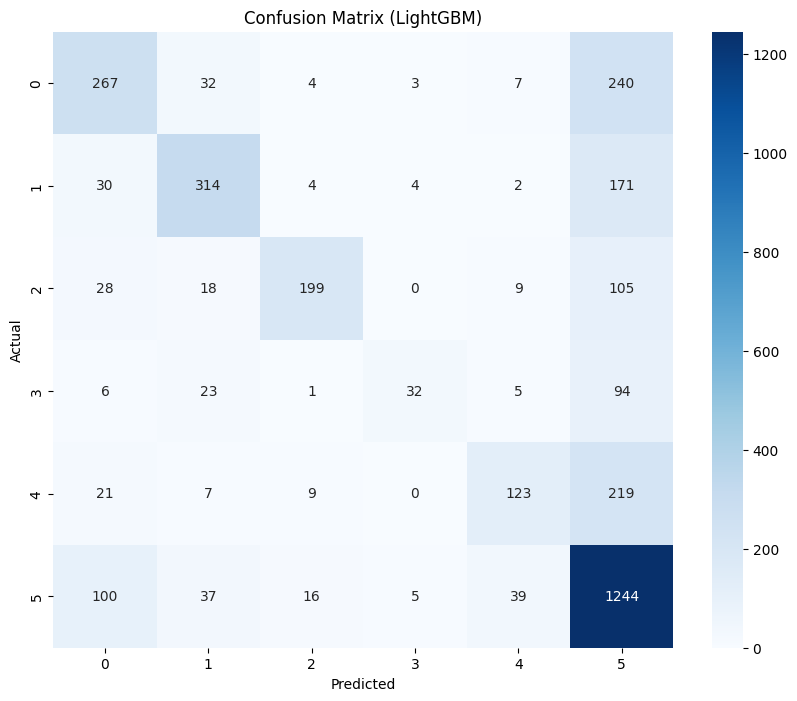

              precision    recall  f1-score   support

           0       0.59      0.48      0.53       553
           1       0.73      0.60      0.66       525
           2       0.85      0.55      0.67       359
           3       0.73      0.20      0.31       161
           4       0.66      0.32      0.44       379
           5       0.60      0.86      0.71      1441

    accuracy                           0.64      3418
   macro avg       0.69      0.50      0.55      3418
weighted avg       0.66      0.64      0.62      3418



In [16]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = standardized_features
y_labels = np.argmax(label.values, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(n_estimators=1000,
                              max_depth=12,
                              learning_rate=0.05,
                              objective='multiclass',
                              num_class=len(np.unique(y_labels)),
                              verbose=-1)

lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)
y_pred_lgb = lgb_clf.predict(X_test)

# Metrics
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"Accuracy (LightGBM): {accuracy_lgb}")

# Convert class labels to strings
class_names = [str(label) for label in np.unique(y_labels)]

# Confusion Matrix
conf_mat_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_lgb, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_labels), yticklabels=np.unique(y_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (LightGBM)')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_lgb, target_names=class_names))

In [17]:
from sklearn.metrics import roc_curve, auc, mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score

# Predict probabilities
y_probs_lgb = lgb_clf.predict_proba(X_test)

# Calculate MSE and MAE
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

# Accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)

# Precision
precision_lgb = precision_score(y_test, y_pred_lgb, average='macro')

# Recall
recall_lgb = recall_score(y_test, y_pred_lgb, average='macro')

# F1-score
f1_lgb = f1_score(y_test, y_pred_lgb, average='macro')

# Print the results
print("Metrics for LightGBM:")
print(f"Mean Squared Error (MSE): {mse_lgb}")
print(f"Mean Absolute Error (MAE): {mae_lgb}")
print(f"Accuracy: {accuracy_lgb}")
print(f"Precision: {precision_lgb}")
print(f"Recall: {recall_lgb}")
print(f"F1-score: {f1_lgb}")

Metrics for LightGBM:
Mean Squared Error (MSE): 4.265359859566998
Mean Absolute Error (MAE): 1.1003510825043885
Accuracy: 0.6375073142188414
Precision: 0.6942595952590697
Recall: 0.5036365280428873
F1-score: 0.5528224539955563


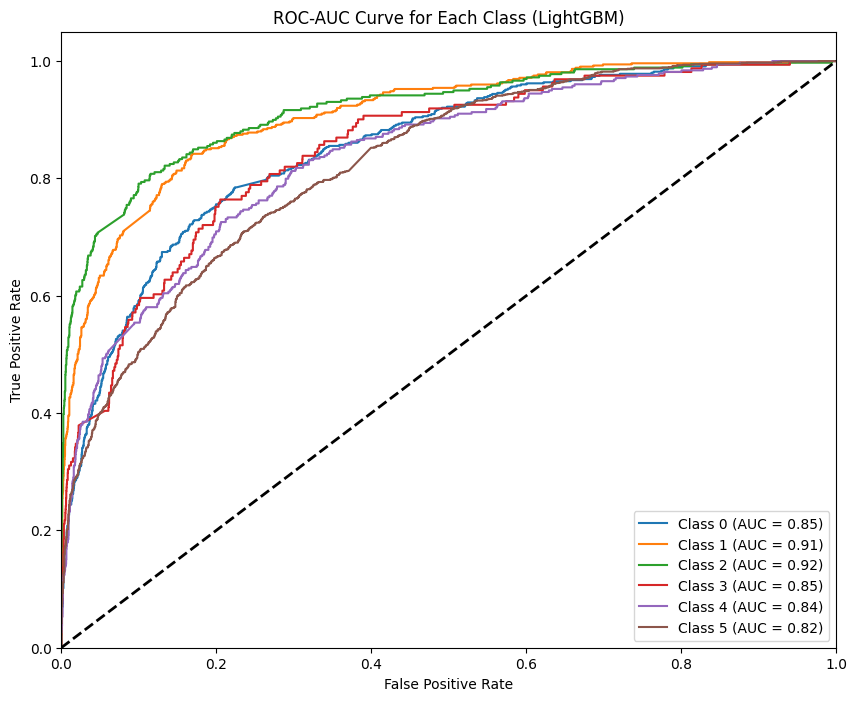

In [18]:
# Plot ROC curve for each class
fpr_lgb = dict()
tpr_lgb = dict()
roc_auc_lgb = dict()
for i in range(len(np.unique(y_labels))):
    fpr_lgb[i], tpr_lgb[i], _ = roc_curve(y_test == i, y_probs_lgb[:, i])
    roc_auc_lgb[i] = auc(fpr_lgb[i], tpr_lgb[i])

plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_labels))):
    plt.plot(fpr_lgb[i], tpr_lgb[i], label=f'Class {i} (AUC = {roc_auc_lgb[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Each Class (LightGBM)')
plt.legend(loc="lower right")
plt.show()

# **Infer Test and Create Submission CSV**

In [19]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [20]:
# FEATURE ENGINEER TEST
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
data_test = np.zeros((len(test), extracted_features.shape[1]))
test_eeg = np.zeros((len(test), 10000, 19))

for k in range(len(test)):
    row = test.iloc[k]
    s = int(row.eeg_id)
    eeg_test = pd.read_parquet(f'{PATH2}{s}.parquet')
    eeg_test = eeg_test.iloc[:, :-1]
    #eeg_test = eeg_test.iloc[:, [col for col in range(eeg_test.shape[1]) if col not in [8, 9, 10]]]
    start_time_point = int((eeg_test.shape[0] - 10_000) // 2)
    eeg_test_slice = eeg_test.iloc[start_time_point : start_time_point + 10_000, :]
    
    test_eeg[k, :, :] = eeg_test_slice
    features_test = extract_eeg_features(test_eeg)
    print("Shape of features_test:", features_test.shape)
    data_test = features_test
print("Shape of data_test:", data_test.shape)

Shape of features_test: (1, 152)
Shape of data_test: (1, 152)


In [21]:
predictions_proba = lgb_clf.predict_proba(data_test)
class_names = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
probabilities_df = pd.DataFrame(predictions_proba, columns=class_names)
print(probabilities_df.head(1))

   seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote
0      0.000518  0.000005   0.00006   0.000005   0.000004    0.999407


In [22]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = probabilities_df
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.000518,0.000005,0.00006,0.000005,0.000004,0.999407


In [23]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float64

In [24]:
from scipy.special import rel_entr

# Get predicted probabilities for each class
y_pred_prob_lgb = lgb_clf.predict_proba(X_test)

# Convert true labels to one-hot encoding
y_true_onehot_lgb = np.zeros((y_test.size, y_pred_prob_lgb.shape[1]))
y_true_onehot_lgb[np.arange(y_test.size), y_test] = 1

# Compute KL divergence
kl_divergence_lgb = np.mean(np.sum(rel_entr(y_true_onehot_lgb, y_pred_prob_lgb), axis=1))

print(f"KL Divergence (LightGBM): {kl_divergence_lgb}")

KL Divergence (LightGBM): 1.2108936157073646
